In [51]:
import torch
import numpy as np
import torchvision
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
def filterByScore(pred, scoreThreshold, nmsThreshold, nms = True):
  outputs = []

  if nms:
    nmsOutputs = []
    for i in range(len(pred)):
      boxes = pred[i]['boxes']
      labels = pred[i]['labels']
      scores = pred[i]['scores']

      filter = pred[i]['scores'] > scoreThreshold
      output = {
        'boxes' : boxes[filter],
        'labels' : labels[filter],
        'scores' : scores[filter]
        }
      outputs.append(output)

      nms = torchvision.ops.nms(output['boxes'],output['scores'], nmsThreshold)
      nmsOutput = {
          'boxes' : boxes[nms],
          'labels' : labels[nms],
          'scores' : scores[nms]
      }
      nmsOutputs.append(nmsOutput)
    return nmsOutputs
  else:
    for i in range(len(pred)):
      boxes = pred[i]['boxes']
      labels = pred[i]['labels']
      scores = pred[i]['scores']

      filter = pred[i]['scores'] > scoreThreshold
      output = {
        'boxes' : boxes[filter],
        'labels' : labels[filter],
        'scores' : scores[filter]
        }
      outputs.append(output)
      return outputs

In [52]:
def plotBoxes(image, pred, classNames):
  image = image.to(torch.uint8)
  image = image.permute(1,2,0)
  image = image.cpu()

  boxes = pred['boxes'].cpu().detach()
  boxes[:,(0,2)] *= image.shape[1]/512
  boxes[:,(1,3)] *= image.shape[0]/512
  labels = pred['labels'].cpu().detach()
  scores = pred['scores'].cpu().detach()

  fig, ax = plt.subplots(1, figsize=(12, 8))
  ax.imshow(image)
  ax.set_xlim([0, image.shape[1]])
  ax.set_ylim([image.shape[0], 0])

  for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box.tolist()
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1,y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    className = classNames[label]
    text = f'{className} : {score:.3f}'
    ax.text(x1, y1-5, text, fontsize = 12, color = 'white', backgroundcolor = 'red')

  ax.axis('off')
  plt.show()

In [53]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
numOfClasses = 2
inFeatures = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(inFeatures, numOfClasses)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/faster_rcnn_weights.pth', map_location=torch.device('cpu' if torch.cuda.is_available() is False else 'cuda:0')))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
imgTransforms = v2.Compose([
    v2.Resize((512,512)),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])
def inference(imgPath):
  img = read_image(imgPath)
  orgImg = img.detach().clone()
  img = imgTransforms(img).to(device)

  model.eval()
  with torch.no_grad():
    pred = model(img.unsqueeze(0))
  filter = filterByScore(pred, 0.6, 0.8, nms = True)
  classNames = ['Background','Car']
  plotBoxes(orgImg, filter[0], classNames)

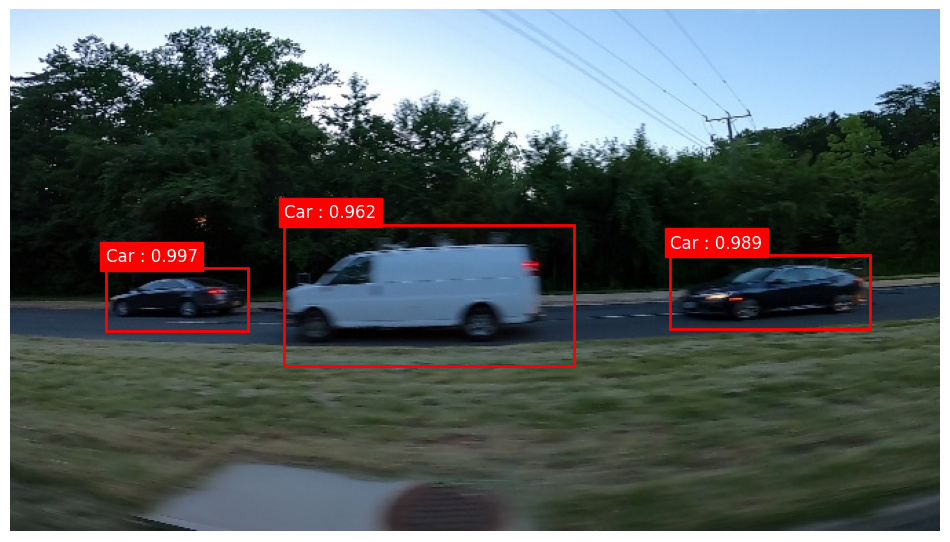

In [57]:
imagePath = '/content/drive/MyDrive/Datasets/Car Object Detection/data/testing_images/vid_5_26720.jpg'
inference(imagePath)